# The World Factbook Analysis
* Found this CIA's World Factbook data set (2015) as "Single-File SQLite" on Git and enabled IPython magic functions to be able to use SQLite in Jupyter environment. Made quick data quality check & exploratory analysis. https://github.com/factbook/factbook.sql/releases

In [71]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

In [67]:
%%sql

SELECT *
  FROM sqlite_master
 WHERE type='table'; 

 * sqlite:///factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


# Exploratory analysis in SQL & Pandas:

In [195]:
%%sql 
SELECT *
FROM facts
LIMIT 10

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46
6,ac,Antigua and Barbuda,442,442,0,92436,1.24,15.85,5.69,2.21
7,ar,Argentina,2780400,2736690,43710,43431886,0.93,16.64,7.33,0.0
8,am,Armenia,29743,28203,1540,3056382,0.15,13.61,9.34,5.8
9,as,Australia,7741220,7682300,58920,22751014,1.07,12.15,7.14,5.65
10,au,Austria,83871,82445,1426,8665550,0.55,9.41,9.42,5.56


# 1 Inspecting the total number of rows:

In [44]:
%%sql
SELECT COUNT (*)
  FROM facts

 * sqlite:///factbook.db
Done.


COUNT (*)
261


# 2 Inspecting the number of unique countries:

* If the same as total number of rows no duplicates

In [49]:
%%sql
SELECT COUNT (DISTINCT name)
  FROM facts

 * sqlite:///factbook.db
Done.


COUNT (DISTINCT name)
261


# 3 Checking again for duplicates:

In [50]:
%%sql
SELECT code, name, COUNT (*)
 from facts
    GROUP BY code, name
    HAVING COUNT(*) > 1

 * sqlite:///factbook.db
Done.


code,name,COUNT (*)


# 4 Checking for NULL values:

In [53]:
%%sql
SELECT * 
FROM facts 
WHERE coalesce (area, area_land, area_water, population, population_growth, birth_rate, death_rate , migration_rate)
IS NULL

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
210,fs,French Southern and Antarctic Lands,None,None,None,None,None,None,None,None
249,um,United States Pacific Island Wildlife Refuges,None,None,None,None,None,None,None,None
256,xq,Arctic Ocean,None,None,None,None,None,None,None,None
257,zh,Atlantic Ocean,None,None,None,None,None,None,None,None
258,xo,Indian Ocean,None,None,None,None,None,None,None,None
259,zn,Pacific Ocean,None,None,None,None,None,None,None,None
260,oo,Southern Ocean,None,None,None,None,None,None,None,None


# 5 Leaving out the rows that have null across all the columns (e.g.oceans):
* There are still some left with "None" across the cells (e.g. areas that are not populated etc.)

In [249]:
%%sql
SELECT * 
FROM facts 
WHERE coalesce (area, area_land, area_water, population_growth, birth_rate, death_rate , migration_rate)
IS NOT NULL
LIMIT 10

 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46
6,ac,Antigua and Barbuda,442,442,0,92436,1.24,15.85,5.69,2.21
7,ar,Argentina,2780400,2736690,43710,43431886,0.93,16.64,7.33,0.0
8,am,Armenia,29743,28203,1540,3056382,0.15,13.61,9.34,5.8
9,as,Australia,7741220,7682300,58920,22751014,1.07,12.15,7.14,5.65
10,au,Austria,83871,82445,1426,8665550,0.55,9.41,9.42,5.56


# 6 Looking for outliers, using z-score:
* Issue below is that "stdev" is not on the list of aggregate functions in sql lite, see error &  https://www.sqlite.org/lang_aggfunc.html 
* That's why I'll switch to Pandas to deal with outliers.

In [143]:
%%sql
SELECT name, (area, area - avg(area)) / stdev(area)
   from (SELECT * 
FROM facts 
WHERE coalesce (area, area_land, area_water, population, population_growth, birth_rate, death_rate , migration_rate)
IS NOT NULL)

 * sqlite:///factbook.db
(sqlite3.OperationalError) no such function: stdev
[SQL: SELECT name, (area, area - avg(area)) / stdev(area)
   from (SELECT * 
FROM facts 
WHERE coalesce (area, area_land, area_water, population, population_growth, birth_rate, death_rate , migration_rate)
IS NOT NULL)]
(Background on this error at: http://sqlalche.me/e/14/e3q8)


# 7 Working with data frames in Pandas 

In [232]:
import pandas as pd
import numpy as np
import scipy.stats as stats
df = pd.read_excel('factbook.xlsx')
df['population'] = df['population'].fillna(0) # add 0 where NaN
print(df.head(5))

   id code         name       area  area_land  area_water  population  \
0   1   af  Afghanistan   652230.0   652230.0         0.0  32564342.0   
1   2   al      Albania    28748.0    27398.0      1350.0   3029278.0   
2   3   ag      Algeria  2381741.0  2381741.0         0.0  39542166.0   
3   4   an      Andorra      468.0      468.0         0.0     85580.0   
4   5   ao       Angola  1246700.0  1246700.0         0.0  19625353.0   

   population_growth  birth_rate  death_rate  migration_rate  
0               2.32       38.57       13.89            1.51  
1               0.30       12.92        6.58            3.30  
2               1.84       23.67        4.31            0.92  
3               0.12        8.13        6.96            0.00  
4               2.78       38.78       11.49            0.46  


# 8 Calculating z-score: 

In [205]:
df['population_zscore'] = stats.zscore(df['population'])

with pd.option_context('display.max_rows', None, 'display.max_columns', None): # checking the whole list for outliers, criteria: +/- 3 stdev
    print(df.tail(5))
df.to_excel('modified.xlsx')
    
#line with id=253 and z-score=15, obviously outlier and spoils the avg of whole column "population"

      id code             name      area  area_land  area_water    population  \
249  252   pf  Paracel Islands       7.0        7.0         0.0  0.000000e+00   
250  253   pg  Spratly Islands       5.0        5.0         0.0  0.000000e+00   
251  254   we        West Bank    5860.0     5640.0       220.0  2.785366e+06   
252  255   wi   Western Sahara  266000.0   266000.0         0.0  5.708660e+05   
253  261   xx            World       NaN        NaN         NaN  7.256490e+09   

     population_growth  birth_rate  death_rate  migration_rate  \
249                NaN         NaN         NaN             NaN   
250                NaN         NaN         NaN             NaN   
251               1.95       22.99        3.50             0.0   
252               2.82       30.24        8.34             NaN   
253               1.08       18.60        7.80             NaN   

     population_zscore  
249          -0.126039  
250          -0.126039  
251          -0.120105  
252          -0.

In [289]:
df = pd.read_excel('modified.xlsx')
df.drop([253], axis=0, inplace=True) #dropping the row with spike
df
df.to_excel('modified2.xlsx')

# 9 Scatter Plot of birth_rate & dead_rate - Matplotlib

In [8]:
%matplotlib
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_excel('modified2.xlsx')
df.plot.scatter(x='birth_rate', y='death_rate', s=60, c='pink')


Using matplotlib backend: QtAgg


# 10 Scatter Plot of birth_rate & dead_rate - Plotly
* Matplotlib scatter has limitations in terms of being able to dive into the specific points and understand what's happening in each "cluster" (there are also too many data points). Tableau has the zoom in/out functionality but can't activate trial atm so I made research and read about Plotly. You might not be able to Zoom in out on Git but I can share my screen during the presentation and we can explore together.
* e.g. Top right "cluster" with highest birth_rates & dead_rates belongs mainly to African countires etc.

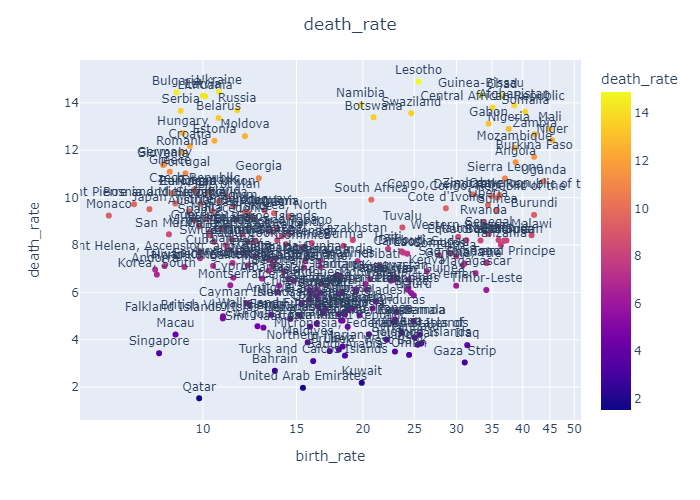

In [4]:
import plotly.express as px
import pandas as pd
pd.options.plotting.backend = "plotly"
df = pd.read_excel('modified2.xlsx')
fig = px.scatter(df, x="birth_rate", y="death_rate", text="name", log_x=True, size_max=100, color="death_rate")
fig.update_traces(textposition='top center')
fig.update_layout(title_text='death_rate', title_x=0.5)
fig.show("png")

# 11 Back to SQL
* The row with an outlier omitted
* Listing the country # 1 among countries with the largest population and the smallest birth_rate (Japan)

In [295]:
%%sql
SELECT *, min(birth_rate) 
   from
    (SELECT * 
  from facts 
WHERE coalesce (area, area_land, area_water, population_growth, birth_rate, death_rate , migration_rate)
IS NOT NULL
AND name <> 'World'
AND population <> 'None'
ORDER BY population desc, birth_rate asc
    LIMIT 50)


 * sqlite:///factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate,min(birth_rate)
85,ja,Japan,377915,364485,13430,126919659,0.16,7.93,9.51,0.0,7.93
